In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import xarray as xr
import os
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import iris
import iris.quickplot as qplt
import iris.plot as iplt
#from iris.experimental.regrid import regrid_weighted_curvilinear_to_rectilinear
import json
import cftime
from itertools import product
from cftime import DatetimeNoLeap
import esmvalcore.preprocessor
import xesmf as xe
import warnings
%matplotlib inline
import seaborn as sns
from scipy import stats
from scipy.interpolate import interp1d
from sklearn import metrics
from nc_processing import calc_spatial_mean
from tqdm import tqdm

#sns.set()

from xmip.preprocessing import rename_cmip6
import matplotlib.path as mpath
import glob

ens_mems = ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r8i1p1f2']

In [2]:
### to do: update all to use siconca, for ease of plotting contour lines

In [3]:
### get ensemble mean tas for both scenarios 

ds_list_tas = []
paths_tas = glob.glob('/badc/deposited2022/arise/data/ARISE/MOHC/UKESM1-0-LL/arise-sai-1p5/*/Amon/tas/gn/*/')

for path in paths_tas:
    #files = os.listdir(path)
    ds = rename_cmip6(xr.open_mfdataset(path+'*.nc'))
    ds_list_tas.append(ds)

DS_ARISE_tas = xr.concat(ds_list_tas, dim='Ensemble_member')

# make SSP245 ensemble mean tas ds
def get_ssp245_ds(variable, table='Amon', grid='gn'):
    ds_list = []
    for es in ens_mems:
        path = '/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp245/{e}/{t}/{v}/{g}/latest/'.format(e=es, t=table,v=variable, g=grid)
        #files = os.listdir(path)
        ds = rename_cmip6(xr.open_mfdataset(path+'*.nc'))
        ds_list.append(ds)
    
    DS = xr.concat(ds_list, dim='Ensemble_member')
    return DS
    
DS_ssp245_tas = get_ssp245_ds(variable='tas', table='Amon')



In [4]:
### restrict tas to arctic

DS_ARISE_tas = DS_ARISE_tas.sel(y=slice(66, 91))
DS_ssp245_tas = DS_ssp245_tas.sel(y=slice(66, 91))


In [5]:
### group to get annual mean tas
DS_ssp245_tas = DS_ssp245_tas.groupby('time.year').mean('time')
DS_ARISE_tas = DS_ARISE_tas.groupby('time.year').mean('time')

In [6]:
### get baseline piControl tas for arctic

#path = '/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Amon/tas/gn/latest/'
#ds = xr.open_mfdataset(path+'*.nc')
#ds = ds.sel(lat=slice(66, 91))

#piCo = calc_spatial_mean(ds.tas, lon_name="lon", lat_name="lat").mean('time')
#piCo = piCo.values*1

# take hard coded value to save time
piCo = 257.9831104902884

In [7]:
da_ssp245 = calc_spatial_mean(DS_ssp245_tas['tas'], lon_name="x", lat_name="y") - piCo
da_arise = calc_spatial_mean(DS_ARISE_tas['tas'], lon_name="x", lat_name="y") - piCo

DF_ssp = pd.DataFrame({'Year':DS_ssp245_tas['year'].values,
                       'tas_em':da_ssp245.mean(dim='Ensemble_member').values})
DF_ARISE = pd.DataFrame({'Year':DS_ARISE_tas['year'].values,
                       'tas_em':da_arise.mean(dim='Ensemble_member').values})

In [8]:
da_ssp245.groupby('Ensemble_member')

DataArrayGroupBy, grouped over 'Ensemble_member'
5 groups with labels 0, 1, 2, 3, 4.

In [9]:
for i in np.arange(0, 5, 1):
    da_ssp245_i = da_ssp245.groupby('Ensemble_member')[i]
    da_ARISE_i = da_arise.groupby('Ensemble_member')[i]

    DF_ssp['tas_{}'.format(i)] = da_ssp245_i.values
    DF_ARISE['tas_{}'.format(i)] = da_ARISE_i.values

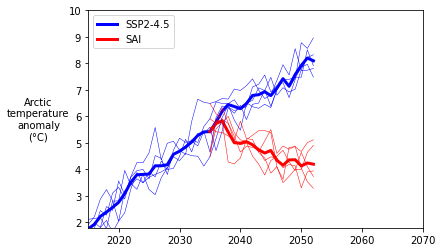

In [10]:
#for top in np.arange(2040, 2070): 
fig, tas_ax = plt.subplots()
year = 2052
tas_ax.plot(DF_ssp[DF_ssp['Year']<=year]['Year'], DF_ssp[DF_ssp['Year']<=year]['tas_em'],
            color = 'blue', label='SSP2-4.5', lw=3)
tas_ax.plot(DF_ARISE[DF_ARISE['Year']<=year]['Year'], DF_ARISE[DF_ARISE['Year']<=year]['tas_em'],
            color='red', label='SAI', lw=3)

for i in np.arange(0, 5, 1):
    tas_ax.plot(DF_ssp[DF_ssp['Year']<=year]['Year'], DF_ssp[DF_ssp['Year']<=year]['tas_{}'.format(i)],
            color = 'blue', lw=0.5)
    tas_ax.plot(DF_ARISE[DF_ARISE['Year']<=year]['Year'], DF_ARISE[DF_ARISE['Year']<=year]['tas_{}'.format(i)],
            color='red', lw=0.5)

tas_ax.set_xlim([2015, 2070])
tas_ax.set_ylim([1.8, 10])
tas_ax.set_ylabel('Arctic\ntemperature\nanomaly\n(°C)', rotation=0,
                  loc='center', verticalalignment='center',
                  labelpad = 30)


tas_ax.legend(loc='upper left')


plt.show()

In [17]:
### get siconc for both scenarios

paths_si = glob.glob('/badc/deposited2022/arise/data/ARISE/MOHC/UKESM1-0-LL/arise-sai-1p5/*/SImon/siconca/gr/*/')

ds_list_si = []
for path in paths_si:
    #files = os.listdir(path)
    ds = xr.open_mfdataset(path+'*.nc')
    ds_list_si.append(ds)
"""
DS_ARISE_siconc = rename_cmip6(xr.concat(ds_list_si, dim='Ensemble_member').mean(dim='Ensemble_member'),
                               rename_dict={'lat_bounds':'vertices_latitude',
                                            'lon_bounds':'vertices_longitude',
                                            'x':'i',
                                            'y':'j',
                                            'vertex':'vertices',
                                            'lat':'latitude',
                                            'lon':'longitude'})
"""
DS_ARISE_siconca = rename_cmip6(xr.concat(ds_list_si, dim='Ensemble_member').mean(dim='Ensemble_member'))
DS_ssp245_siconca = get_ssp245_ds(variable='siconca', table='SImon', grid='gr').mean(dim='Ensemble_member')


In [18]:
month = 9

DS_ARISE_siconca = DS_ARISE_siconca.sel(time=DS_ARISE_siconca.time.dt.month.isin([month]))
DS_ssp245_siconca = DS_ssp245_siconca.sel(time=DS_ssp245_siconca.time.dt.month.isin([month]))

years_arise = DS_ARISE_siconca.time.dt.year
early_years_ssp245 = DS_ssp245_siconca.sel(time=~DS_ssp245_siconca.time.dt.year.isin(years_arise))
early_years_ssp245 = early_years_ssp245.sel(time=slice('2000', '2050'))

# add ssp245 data to arise for period before start of sai
DS_ARISE_siconca = xr.concat([early_years_ssp245, DS_ARISE_siconca.drop('type')], dim='time')
#DS_ARISE_siconc.compute()
# remove post-sai period from ssp245
DS_ssp245_siconca = DS_ssp245_siconca.sel(time=slice('2000', '2071'))
#DS_ssp245_siconc.compute()

In [19]:
## also get PiC siconc
path = '/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/SImon/siconca/gr/latest/'
ds_pic = xr.open_mfdataset(path+'*.nc')

### NEW line below
ds_pic = ds_pic.sel(time=ds_pic.time.dt.month.isin([month]))

ds_pic = ds_pic.mean('time')

In [ ]:

"""
year = 2050
plot_ds_1 = DS_ssp245_siconc.sel(time=DS_ssp245_siconc.time.dt.year == year).assign_coords({'lat':DS_ssp245_siconc.lat,
                                'lon':DS_ssp245_siconc.lon})
plot_ds_2 = DS_ARISE_siconc.sel(time=DS_ARISE_siconc.time.dt.year == year).assign_coords({'lat':DS_ssp245_siconc.lat,
                                'lon':DS_ssp245_siconc.lon})
"""


 36%|███▌      | 20/56 [09:55<18:04, 30.13s/it]/tmp/ipykernel_1057/4088735121.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2, figsize=(10, 6),
100%|██████████| 56/56 [26:33<00:00, 28.45s/it]


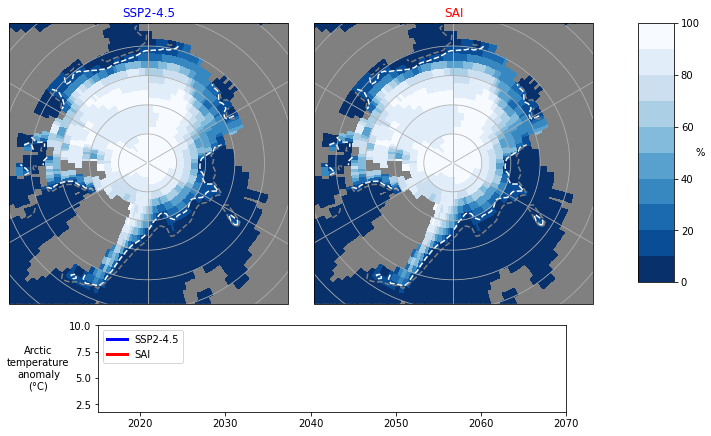

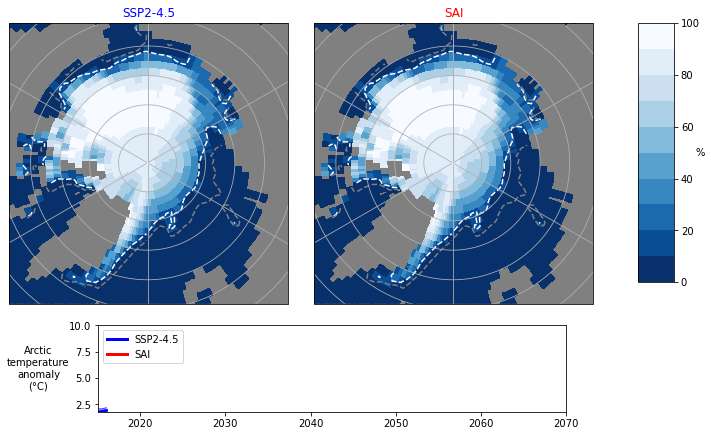

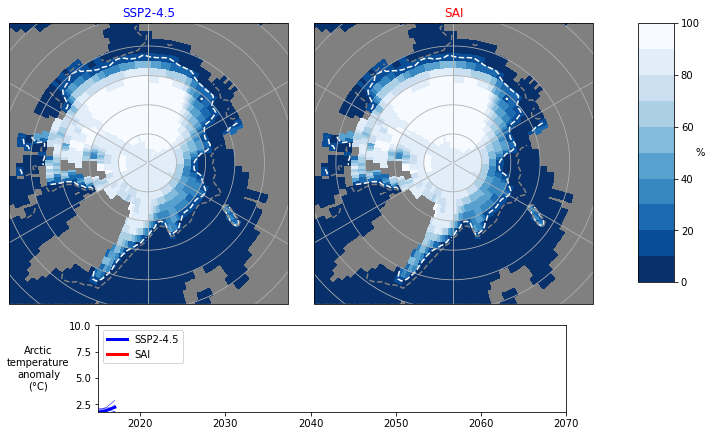

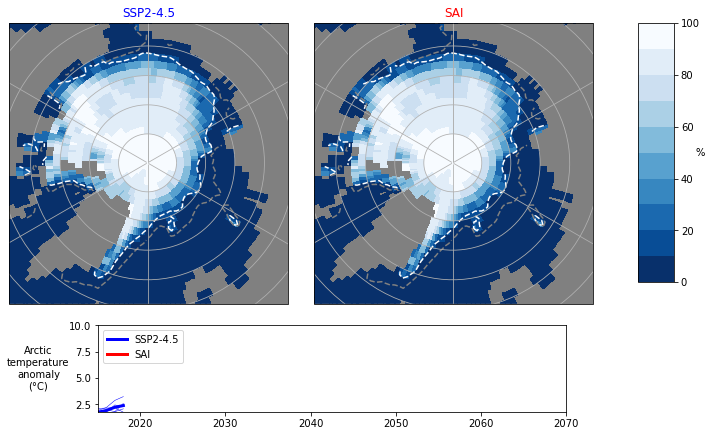

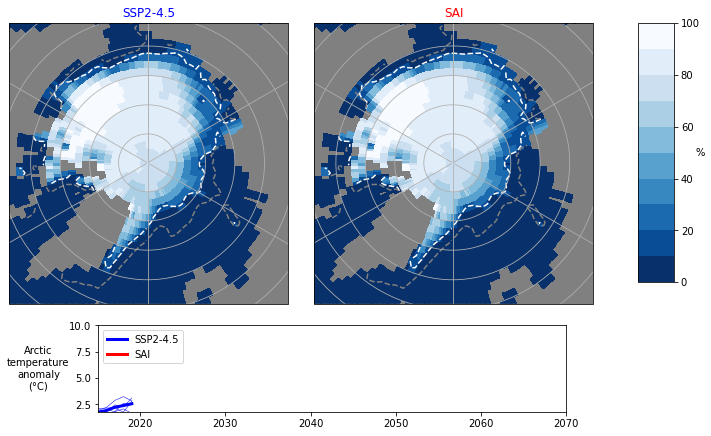

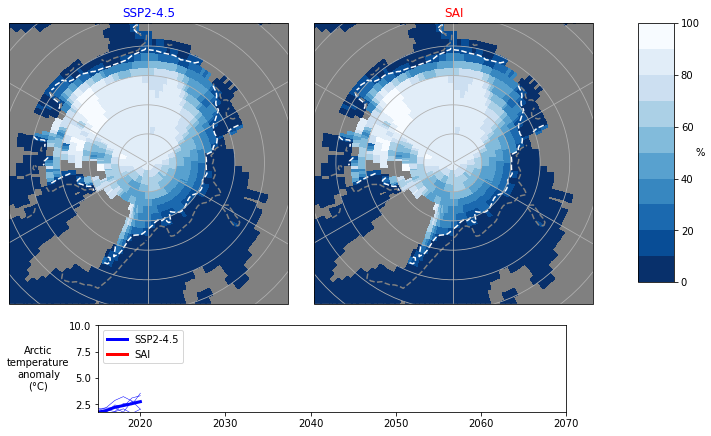

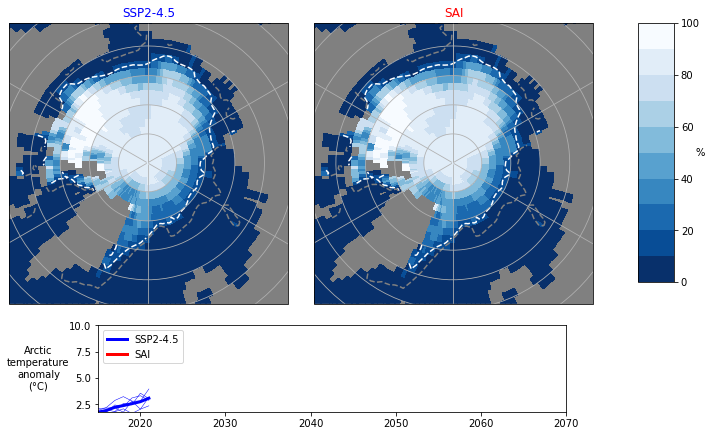

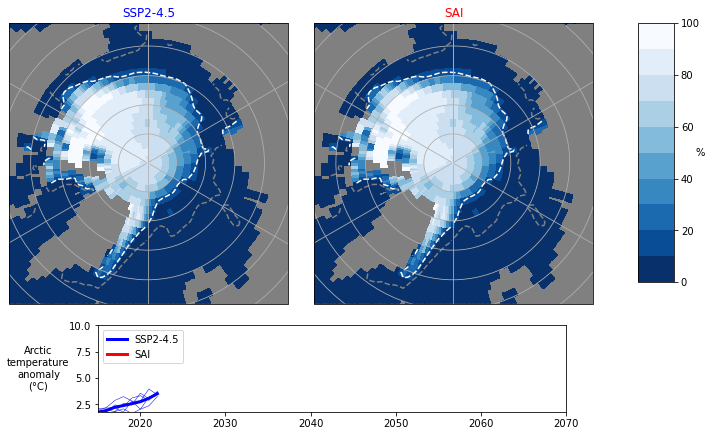

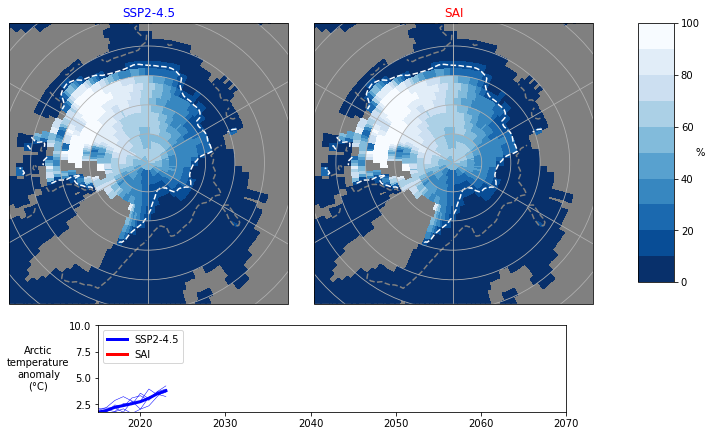

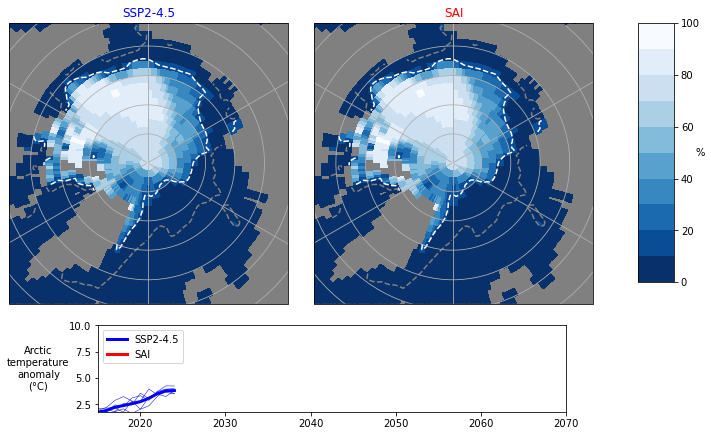

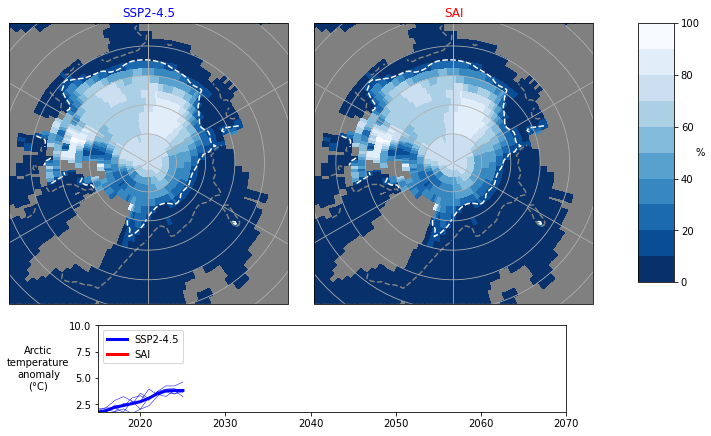

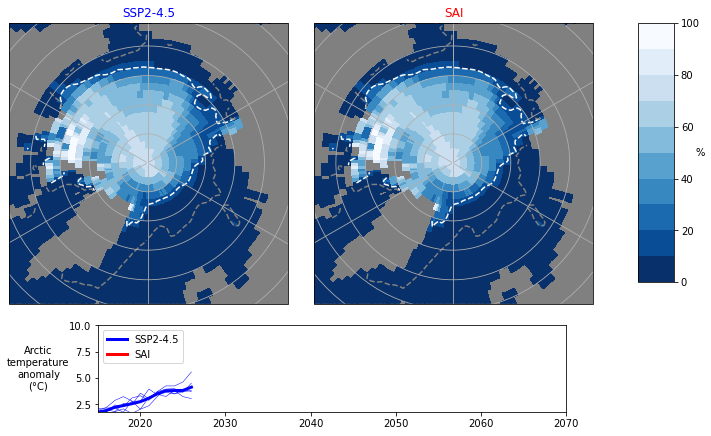

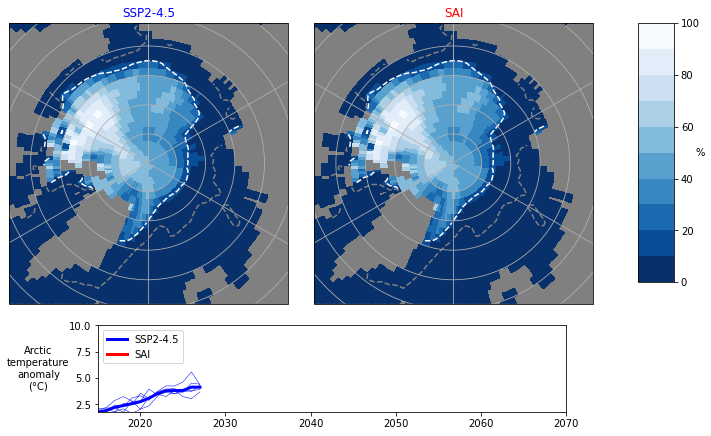

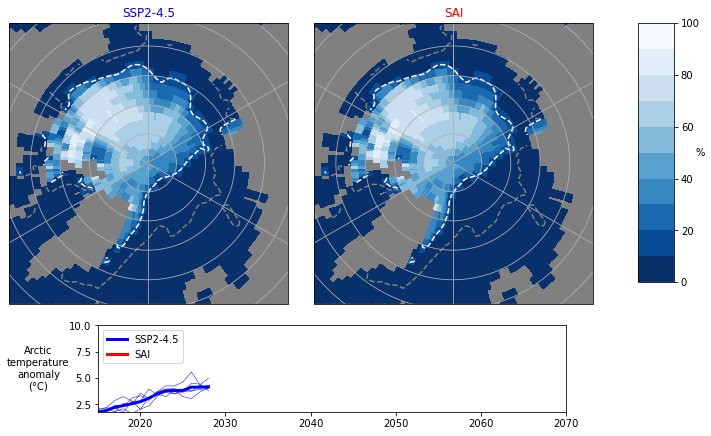

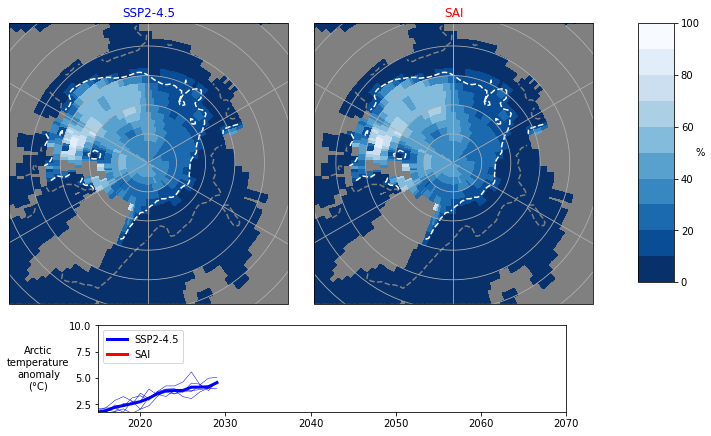

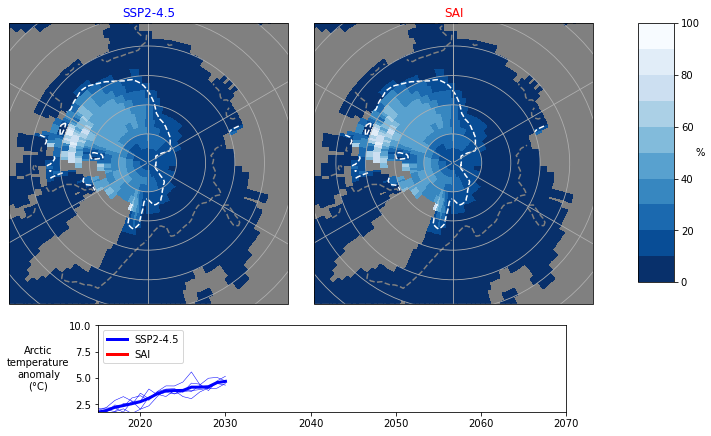

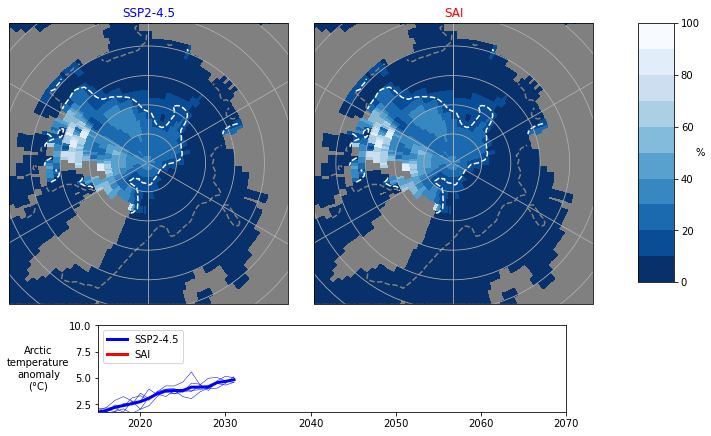

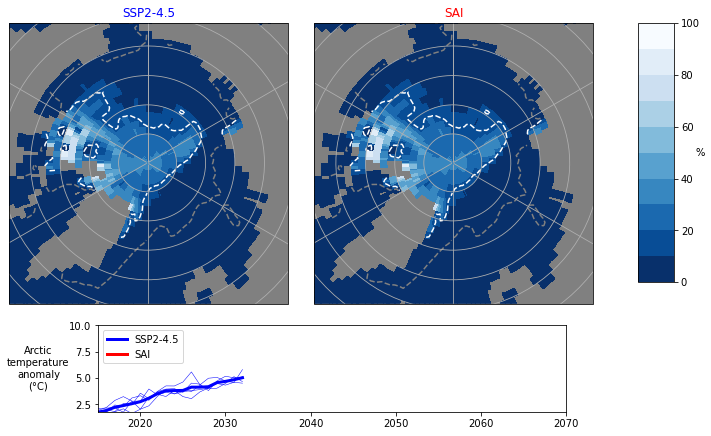

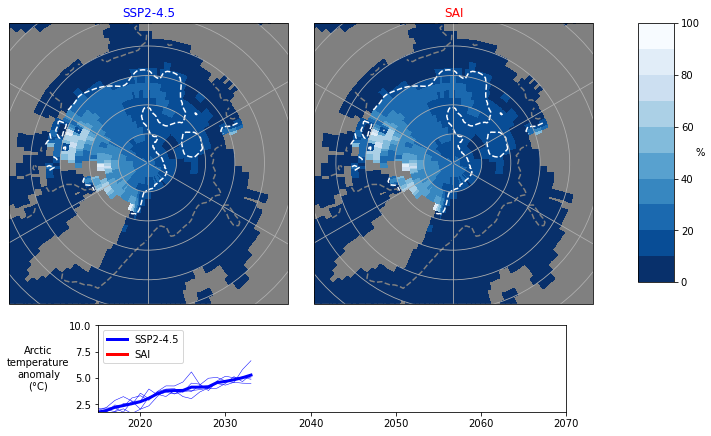

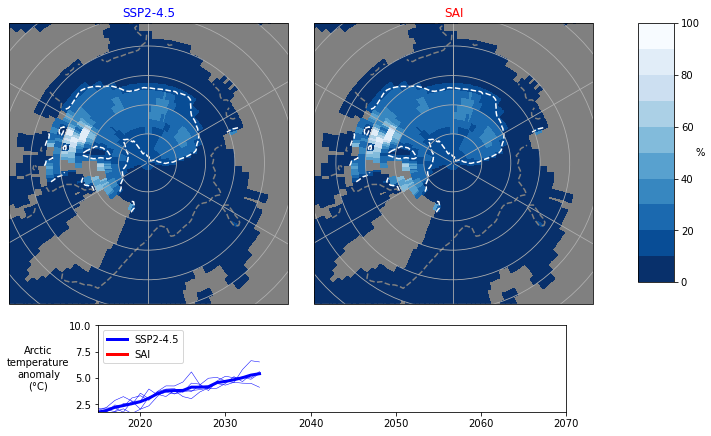

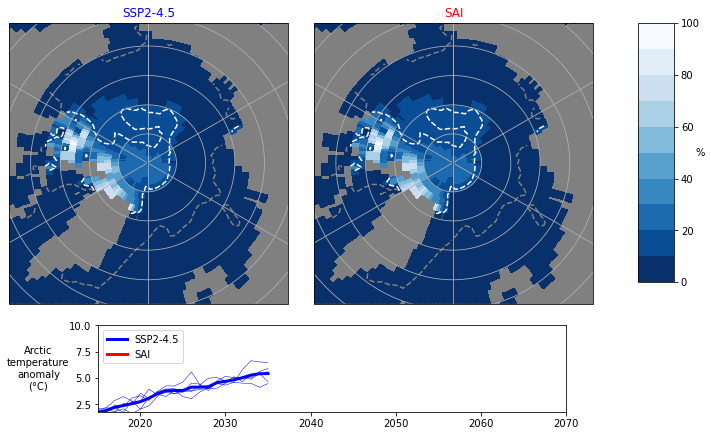

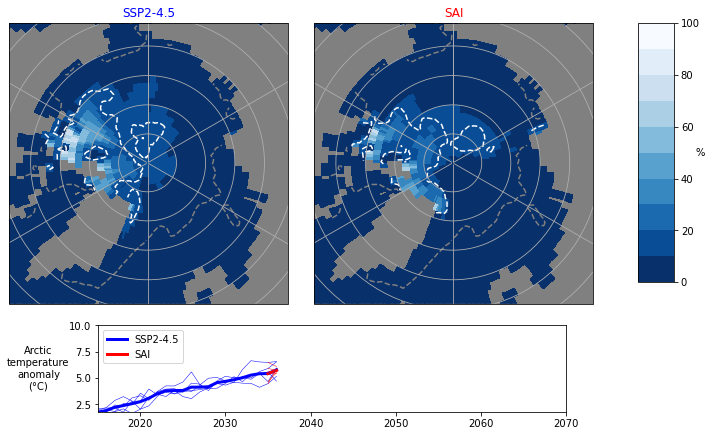

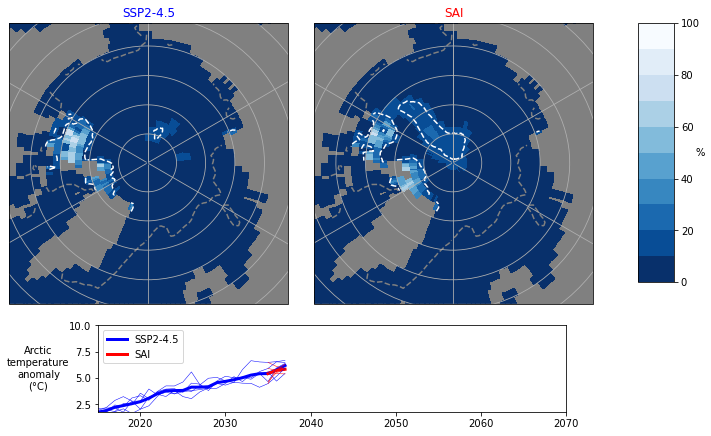

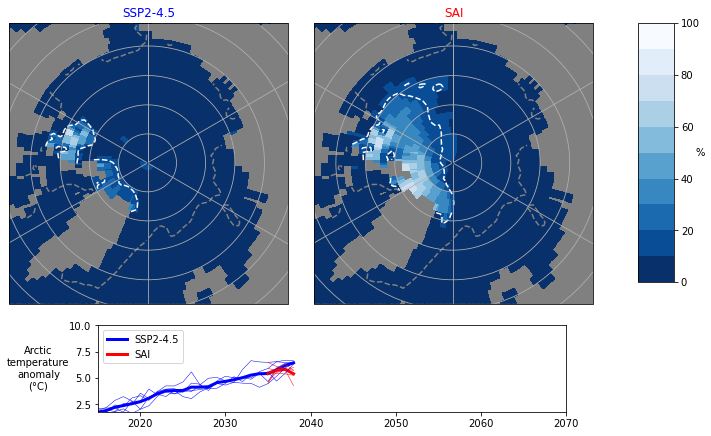

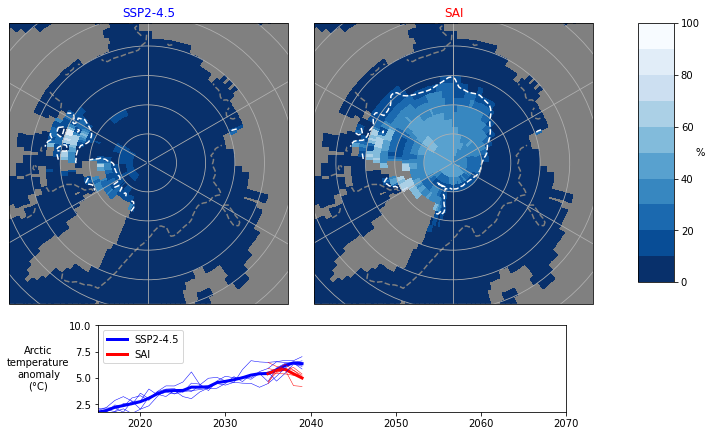

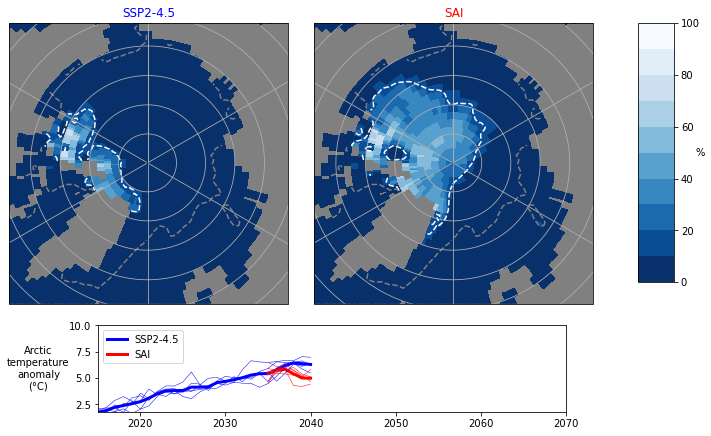

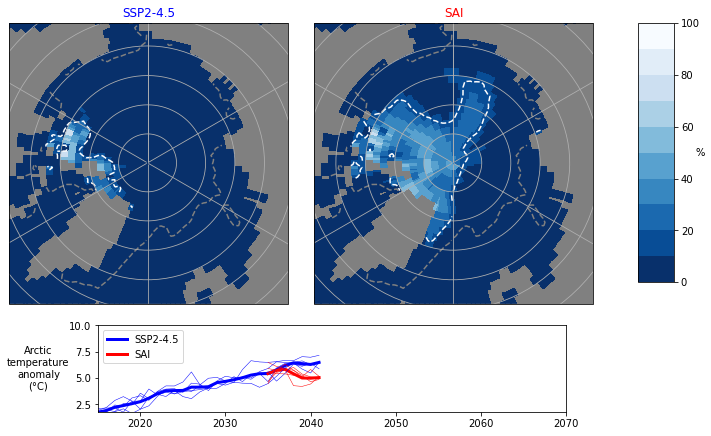

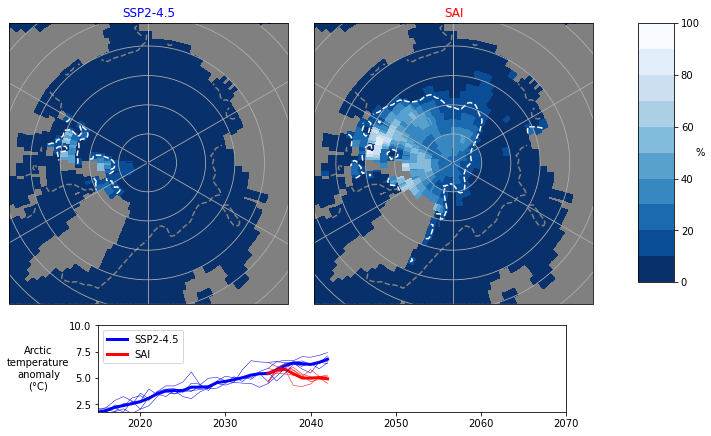

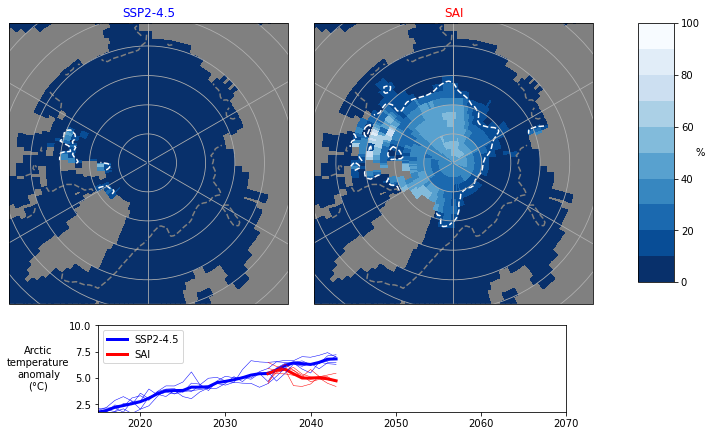

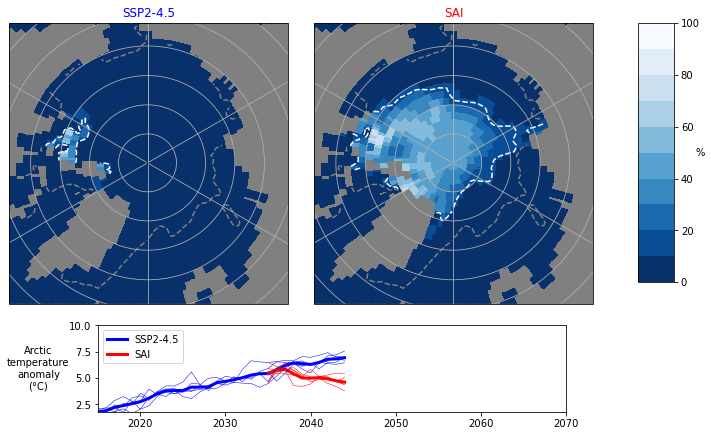

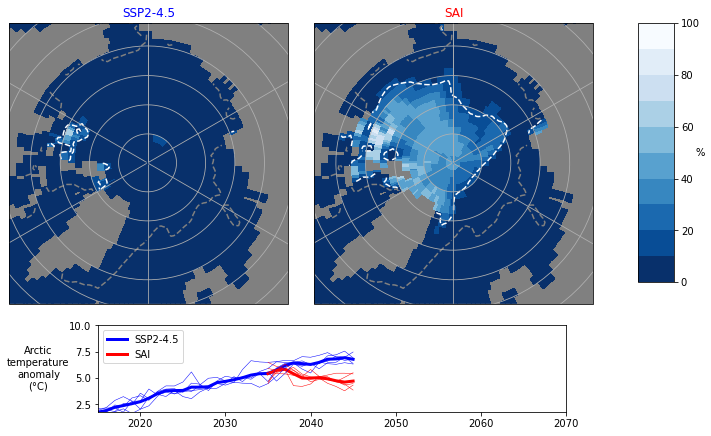

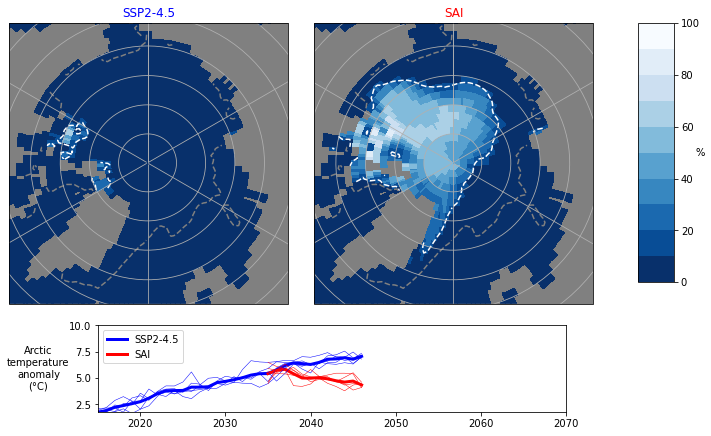

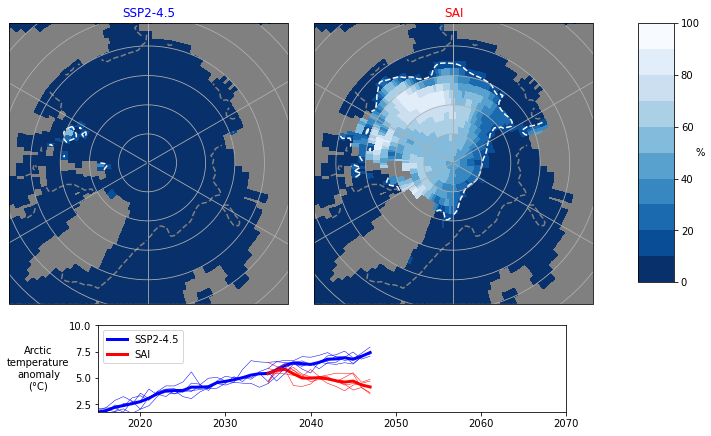

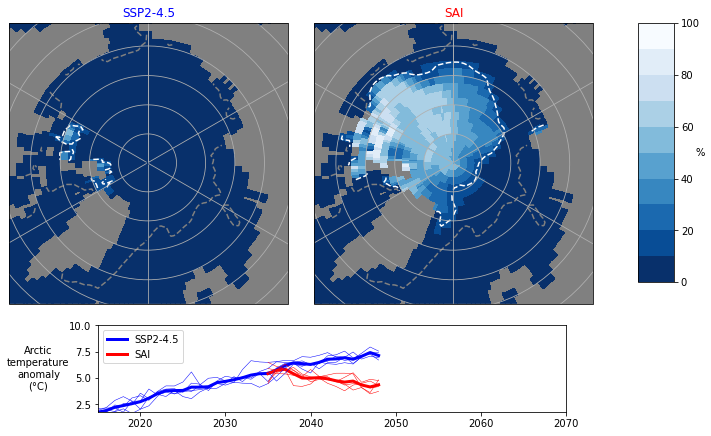

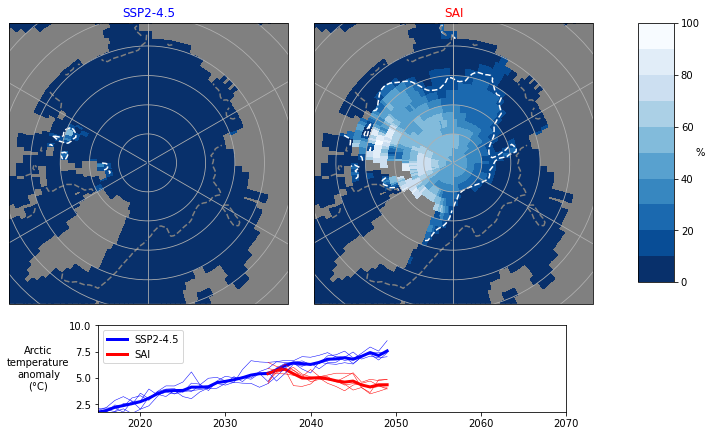

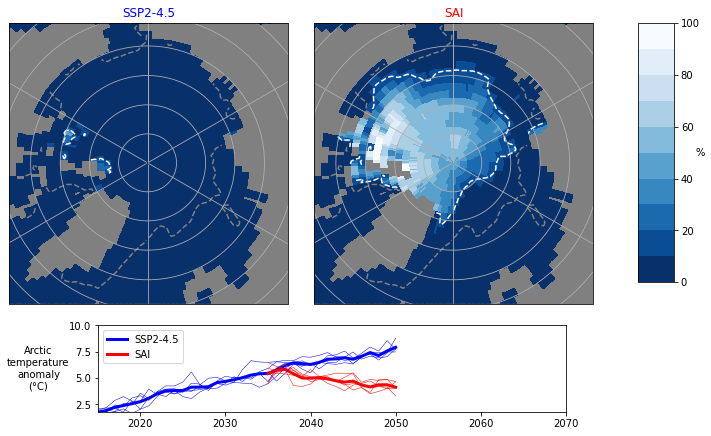

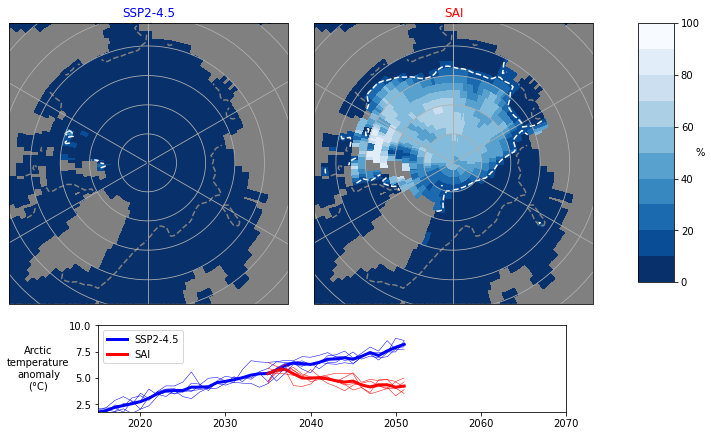

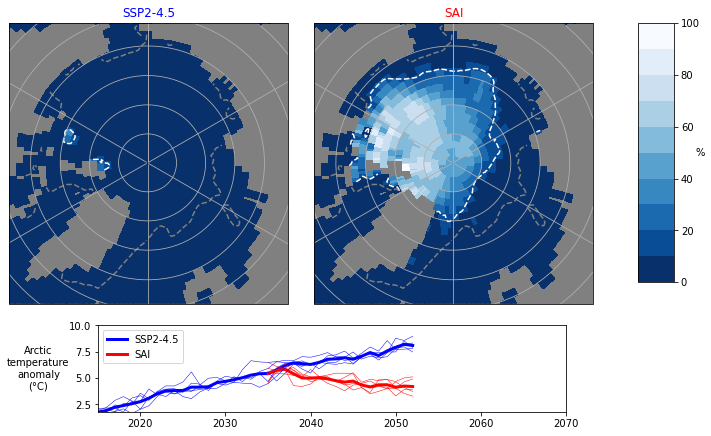

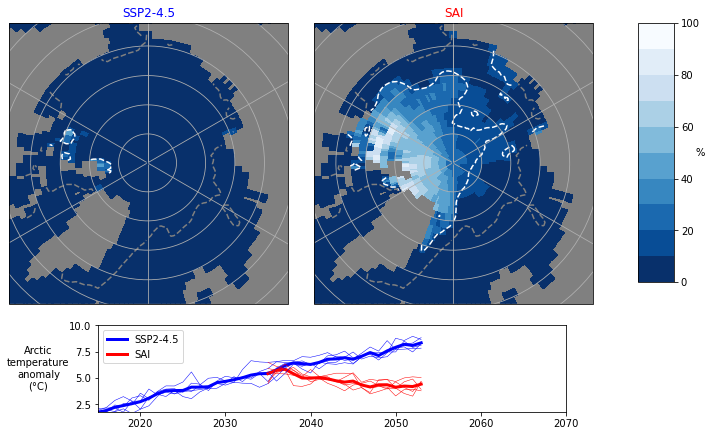

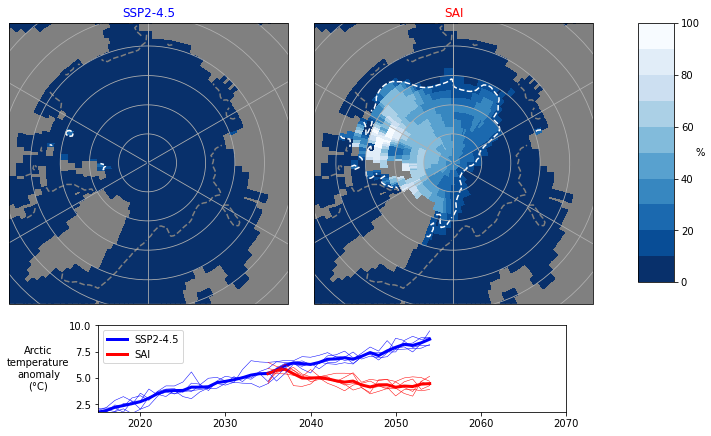

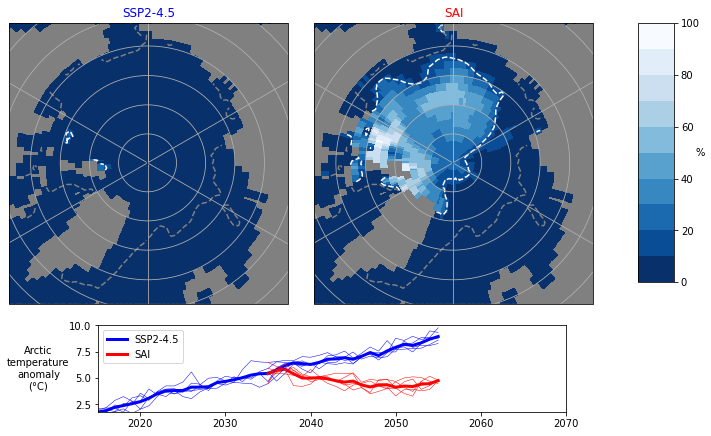

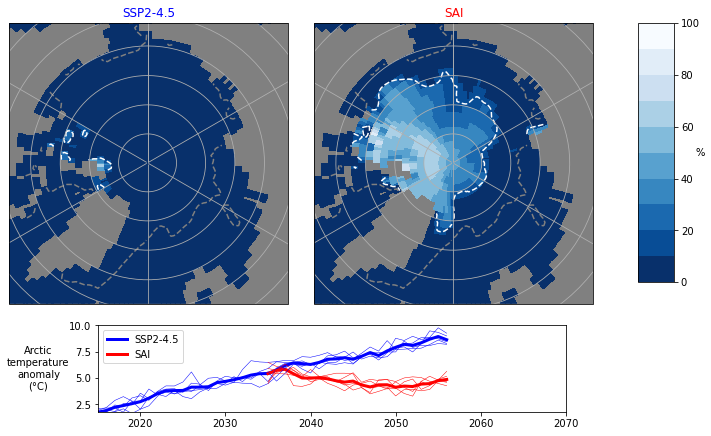

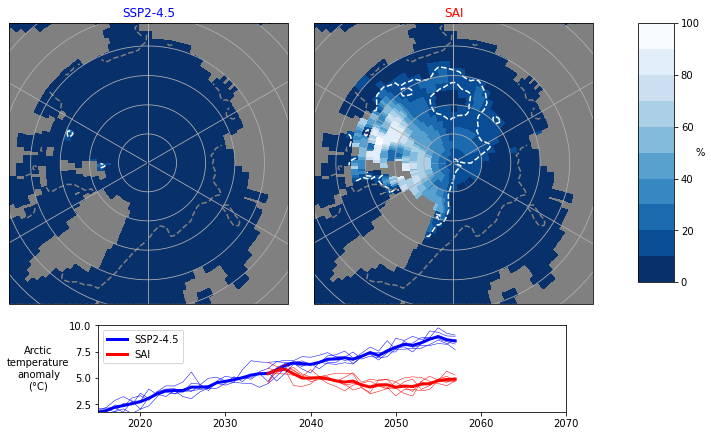

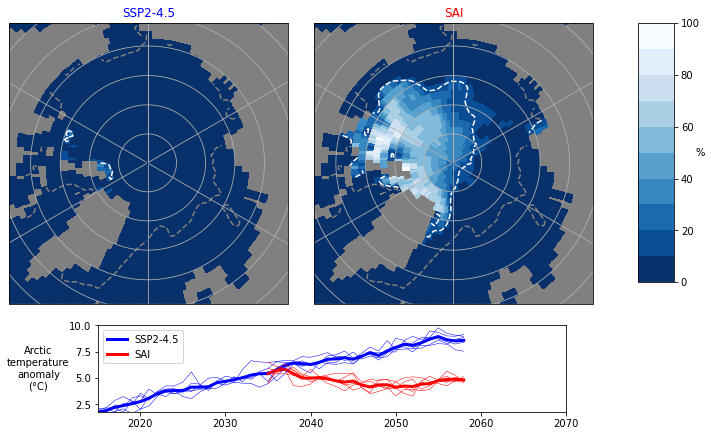

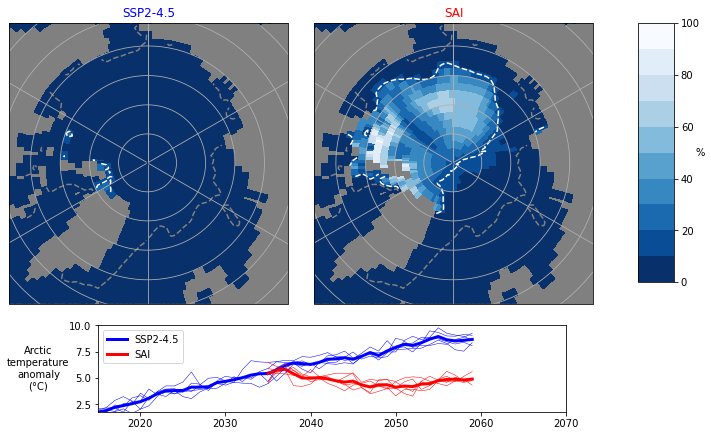

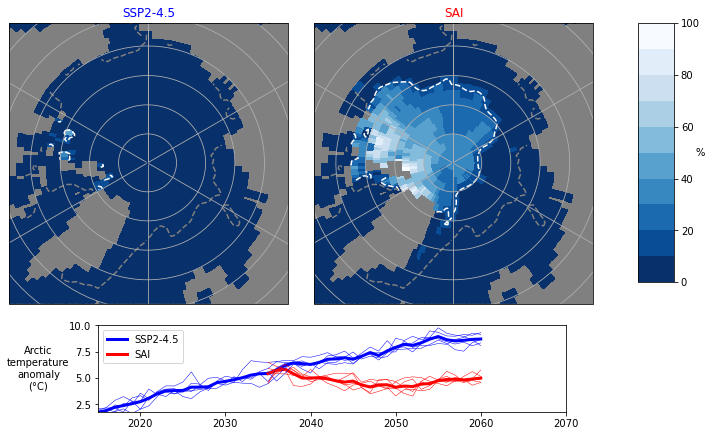

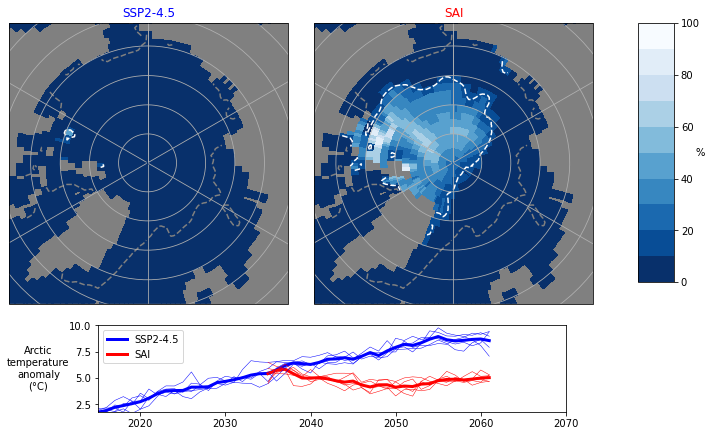

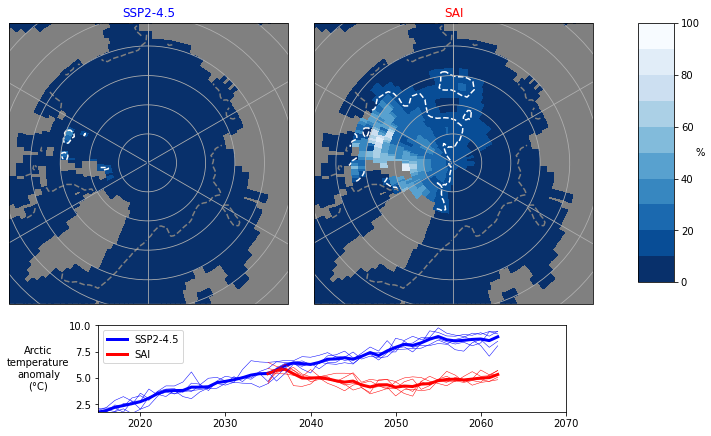

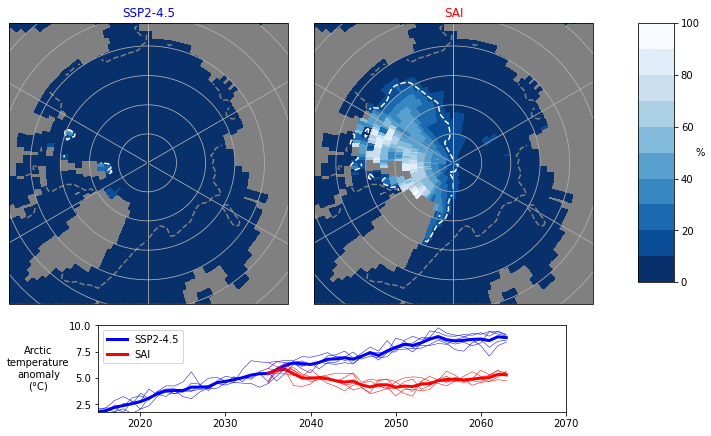

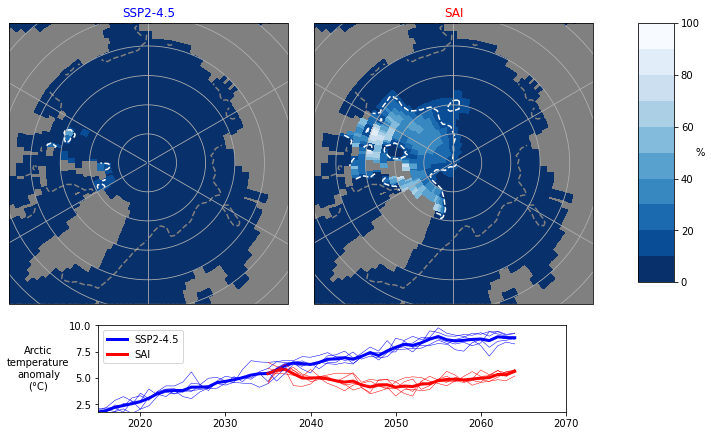

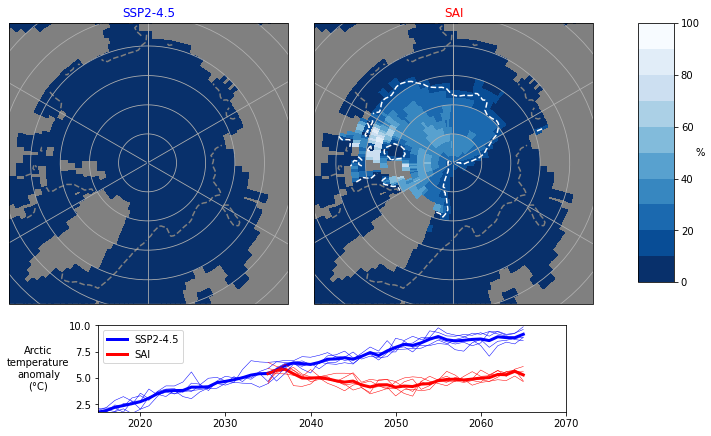

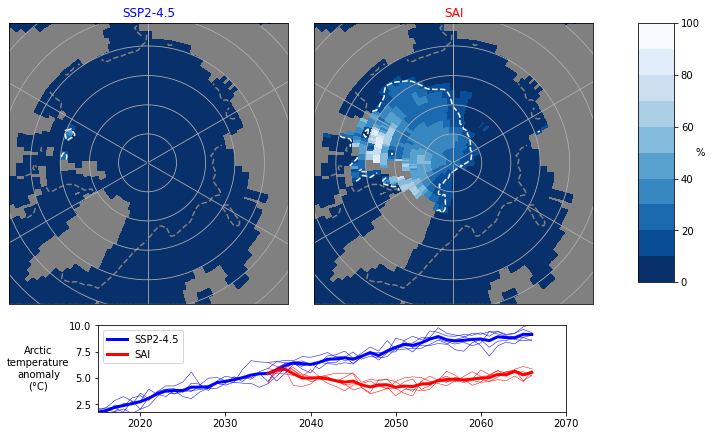

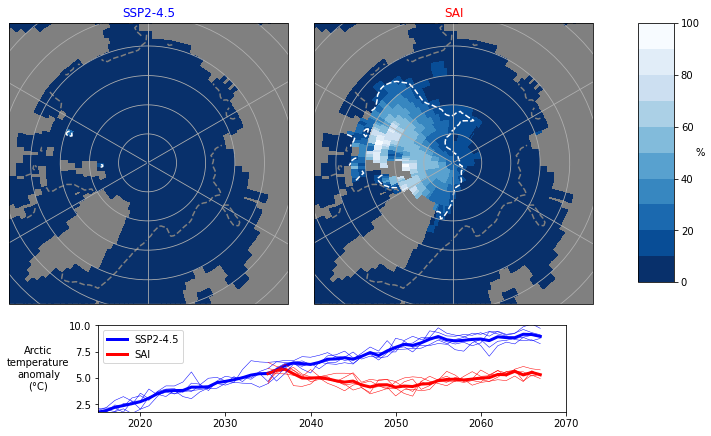

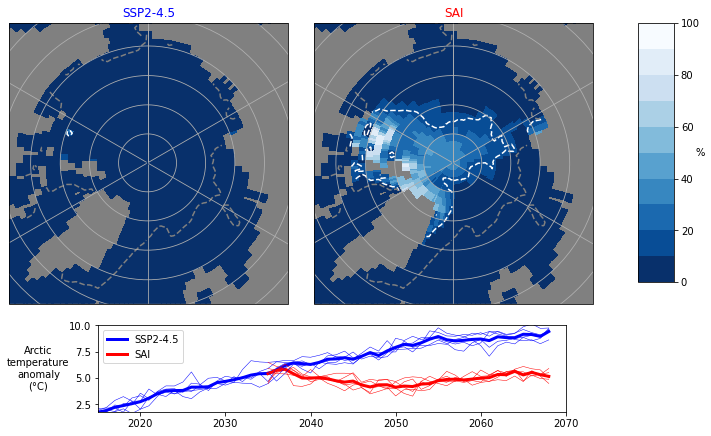

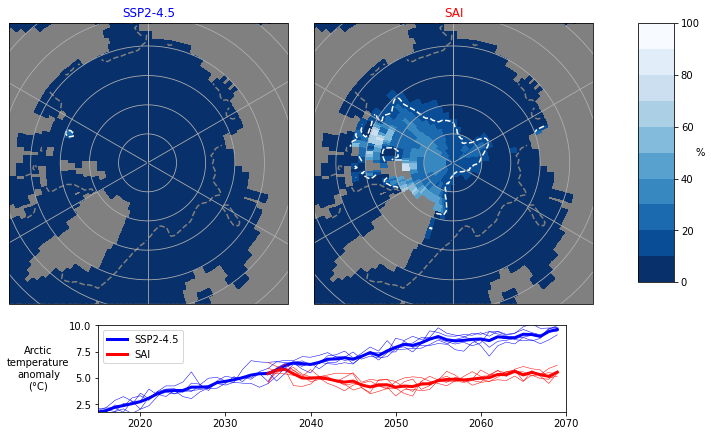

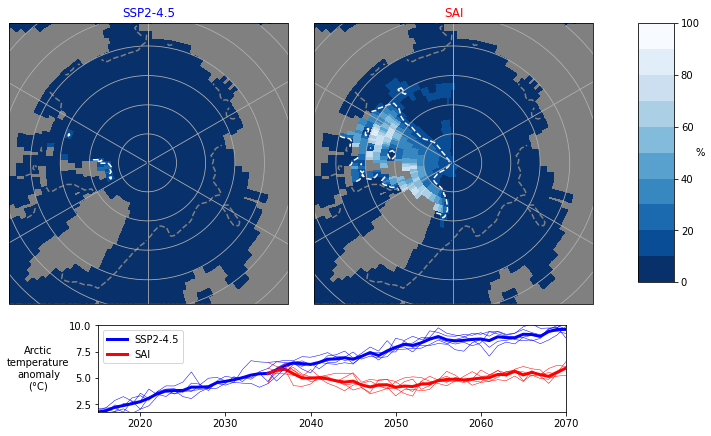

In [20]:
for year in tqdm(np.arange(2015, 2071, 1)):
    plot_ds_1 = DS_ssp245_siconca.sel(time=DS_ssp245_siconca.time.dt.year == year)
    plot_ds_2 = DS_ARISE_siconca.sel(time=DS_ARISE_siconca.time.dt.year == year)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 6), 
                    subplot_kw={'projection':ccrs.NorthPolarStereo(central_longitude=0.0), 
                                'facecolor':'gray'})
    
    #axs[0] = plt.axes()
    #axs[1] = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-30.0), facecolor='gray')
    
    p1 = plot_ds_1.siconca[0].plot.pcolormesh(
        ax=axs[0],
        levels=  np.arange(0, 110, 10),
        cmap='Blues_r',
        transform=ccrs.PlateCarree(), x="x", y="y", add_colorbar=False
    )
    
    p3 = plot_ds_1.siconca[0].plot.contour(
                    ax=axs[0],
                    transform=ccrs.PlateCarree(), x="x", y="y",
                    levels=  [15],
                    colors='white',
                    extend='neither',
                    linestyles='dashed',
                    add_colorbar=False
                )
    
    ds_pic.siconca.plot.contour(
                    ax=axs[0],
                    transform=ccrs.PlateCarree(), x="lon", y="lat",
                    levels=  [15],
                    colors='gray',
                    extend='neither',
                    linestyles='dashed',
                    add_colorbar=False
                )
    
    
    p2 = plot_ds_2.siconca[0].plot.pcolormesh(
        ax=axs[1],
        levels=  np.arange(0, 110, 10),
        cmap='Blues_r',
        transform=ccrs.PlateCarree(), x="x", y="y", add_colorbar=False
    )
    
    
    p4 = plot_ds_2.siconca[0].plot.contour(
                    ax=axs[1],
                    transform=ccrs.PlateCarree(), x="x", y="y",
                    levels=  [15],
                    colors=['white'],
                    extend='neither',
                    linestyles='dashed',
                    add_colorbar=False
                )
    
    ds_pic.siconca.plot.contour(
                    ax=axs[1],
                    transform=ccrs.PlateCarree(), x="lon", y="lat",
                    levels=  [15],
                    colors='gray',
                    extend='neither',
                    linestyles='dashed',
                    add_colorbar=False
                )
    
    p1.axes.set_extent([0, 360, 66, 90], ccrs.PlateCarree())
    #p1.axes.coastlines()   
    #p1.set_boundary(map_circle, transform=p2.transAxes)
    
    p2.axes.set_extent([0, 360, 66, 90], ccrs.PlateCarree())
    #p2.axes.coastlines()   
    #p2.set_boundary(map_circle, transform=p3.transAxes)
    
    
    
    axs[0].set_title('SSP2-4.5', color='blue')
    axs[1].set_title('SAI', color='red')
    axs[0].gridlines()
    axs[1].gridlines()
    
    plt.tight_layout()
    
    fig.subplots_adjust(right=0.85, top=0.95)
    cbar_ax = fig.add_axes([0.9, 0.35, 0.05, 0.6])
    cbar = fig.colorbar(p1, cax=cbar_ax, orientation='vertical')
    #cbar.ax.set_ylabel('Sea-ice\nconcentration\n(%)', rotation=0, 
    #                   verticalalignment='center', labelpad =30)
    cbar.ax.set_ylabel('%', rotation=0, 
                       verticalalignment='center', labelpad =0)
    
    
    fig.subplots_adjust(bottom=0.3)
    tas_ax = fig.add_axes([0.15, 0.05, 0.65, 0.2])
    tas_ax.plot(DF_ssp[DF_ssp['Year']<=year]['Year'], DF_ssp[DF_ssp['Year']<=year]['tas_em'],
            color = 'blue', label='SSP2-4.5', lw=3)
    tas_ax.plot(DF_ARISE[DF_ARISE['Year']<=year]['Year'], DF_ARISE[DF_ARISE['Year']<=year]['tas_em'],
                color='red', label='SAI', lw=3)
    
    for i in np.arange(0, 5, 1):
        tas_ax.plot(DF_ssp[DF_ssp['Year']<=year]['Year'], DF_ssp[DF_ssp['Year']<=year]['tas_{}'.format(i)],
                color = 'blue', lw=0.5)
        tas_ax.plot(DF_ARISE[DF_ARISE['Year']<=year]['Year'], DF_ARISE[DF_ARISE['Year']<=year]['tas_{}'.format(i)],
                color='red', lw=0.5)
    
    tas_ax.set_xlim([2015, 2070])
    tas_ax.set_ylim([1.8, 10])
    tas_ax.set_ylabel('Arctic\ntemperature\nanomaly\n(°C)', rotation=0,
                      loc='center', verticalalignment='center',
                      labelpad = 30)
    
    
    tas_ax.legend(loc='upper left')
    #plt.savefig('Figures/siconcs_{m}_tas/{}.jpg', dpi=300)
    plt.savefig('Figures/siconcs_{m}_tas_mr/{y}.png'.format(m=str(month), y=str(year)), dpi=250)

    #plt.show()